## Modelo combinado [lightgbm, xgboost, SVR, Ridge, RF y GBR] para pronosticar el precio de la vivienda
- Cada fila del conjunto de datos describe las características de una casa.
- Nuestro objetivo es predecir el Precio de Venta, dadas estas características.
- Nuestros modelos se evalúan según el error cuadrático medio (RMSE) entre el registro del Precio de venta predicho por nuestro modelo y el registro del Precio de venta real. La conversión de los errores RMSE a una escala logarítmica garantiza que los errores al predecir casas caras y casas baratas afectarán nuestra puntuación por igual.

## Características clave del proceso de entrenamiento del modelo:
- **Validación cruzada:** Usamos validación cruzada 12 veces
- **Modelos:** En cada ejecución de validación cruzada, se ajustan 7 modelos (lightgbm, xgboost, SVR, Ridge, RF y GBR).
- **Combinación:** Combinamos las predicciones de cada modelo para obtener predicciones más sólidas con base en el RMSE de cada modelo por aparte.

### Cargamos las librerías necesarias para nuestro modelo:

In [9]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from pathlib import Path

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

#import os
#print(os.listdir("../input/kernel-files"))

#### Cargamos las variables

In [10]:
DATAPATH = Path(os.getcwd()).parent / 'data'
SEED = 1399

#### Leemos los datos

In [13]:
train = pd.read_csv(DATAPATH / 'train.csv')
print(f'Filas: {train.shape[0]:,}')
print(f'Columnas: {train.shape[1]:,}')
train.head(5)

Filas: 1,460
Columnas: 81


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
test = pd.read_csv(DATAPATH / 'test.csv')
print(f'Filas: {test.shape[0]:,}')
print(f'Columnas: {test.shape[1]:,}')
test.head(5)

Filas: 1,459
Columnas: 80


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [16]:
train.shape, test.shape

((1460, 81), (1459, 80))

Ahora realizamos varias transformaciones y creaciones de nuevas características (feature engineering) en el conjunto de datos con el objetivo de mejorar el rendimiento de los modelos de aprendizaje automático.

In [44]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## Transformaciones de características
Crearemos más funciones calculando las transformaciones logarítmicas y cuadradas de nuestras funciones numéricas.

In [45]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [46]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

## Codificamos las características categóricas

Codificamos numéricamente las características categóricas porque la mayoría de los modelos solo pueden manejar características numéricas.

In [47]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 379)

In [48]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,Total_Home_Quality,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po

In [49]:
all_features.shape

(2917, 379)

In [50]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

## Recreamos los sets de prueba y entrenamiento

In [51]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 378), (1458,), (1459, 378))

# Entrenamos el modelo

## Configuramos validación cruzada y definir métricas de error

In [54]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [55]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

A través de la función GridSearch, encontramos los siguientes valores óptimos en los hiperparámetros a usar en cada modelos:

In [56]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Entrenamiento de los modelos

### Hacemos cross validation para cada uno de los modelos

In [57]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1162 (0.0165)


In [58]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.1361 (0.0162)


In [59]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1109 (0.0186)


In [60]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1114 (0.0161)


In [61]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1386 (0.0162)


In [62]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1118 (0.0162)


### Ajustamos los modelos

In [63]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

stack_gen


In [65]:
print('lightgbm')
lgb_model_full_data = lgb.LGBMRegressor(n_jobs=-1)
lgb_model_full_data.fit(X, train_labels)

lightgbm
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9314
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 277
[LightGBM] [Info] Start training from score 12.024015


LGBMRegressor(n_jobs=-1)

In [67]:
import xgboost as xgb
print('xgboost')
xgb_model_full_data = xgb.XGBRegressor(n_jobs=-1)
xgb_model_full_data.fit(X, train_labels)

xgboost


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [68]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


In [69]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

Ridge


In [70]:
from sklearn.ensemble import RandomForestRegressor

print('RandomForest')
rf_model_full_data = RandomForestRegressor(n_jobs=-1)
rf_model_full_data.fit(X, train_labels)

RandomForest


RandomForestRegressor(n_jobs=-1)

In [72]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


## Combinamos los modelos con base en la ponderación guiada a través de las estadísticas de RMSE de cada uno de los modelos

In [73]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [74]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.06393885874293917


## Graficamos el performance de cada modelo por aparte y del modelo combinado

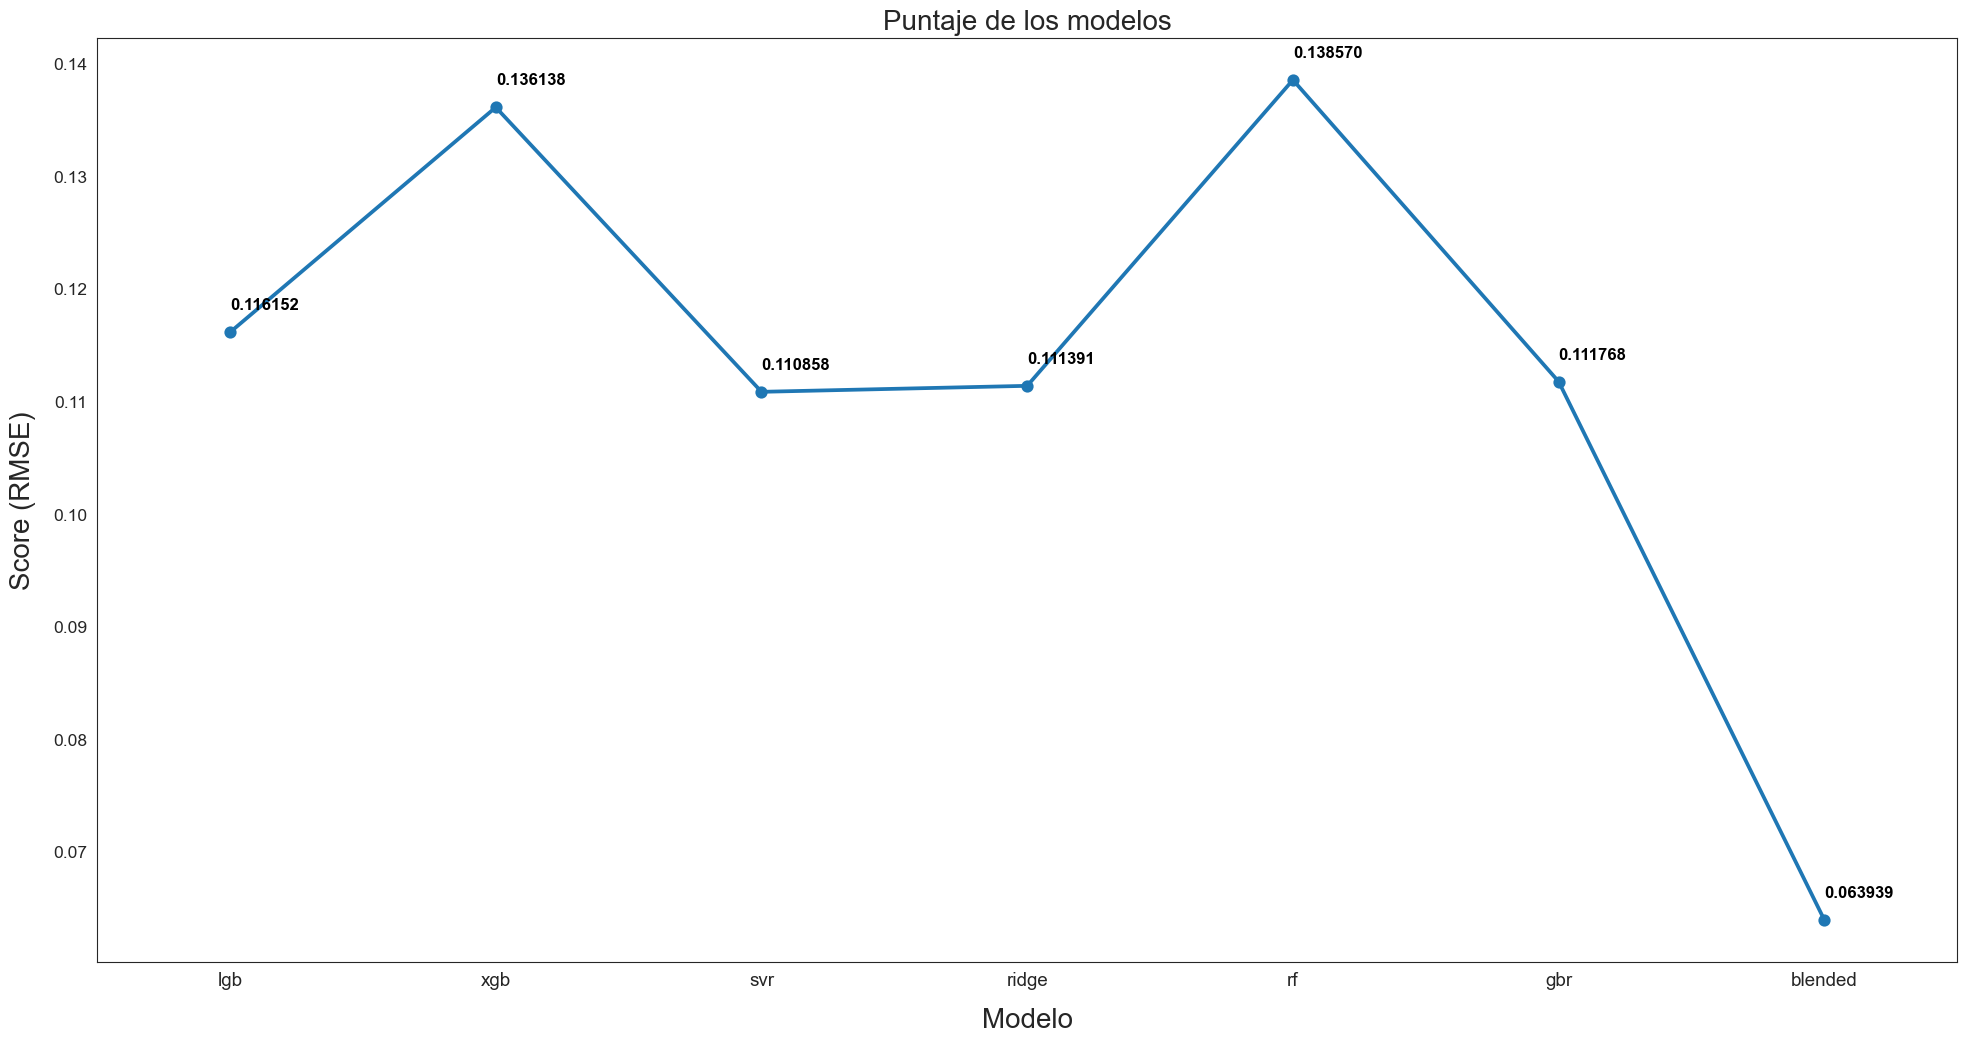

In [77]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers='o', linestyles='-')
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Modelo', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Puntaje de los modelos', size=20)

plt.show()

Podemos observar en el gráfico anterior que el modelo combinado supera con creces a los otros modelos, con un RMSLE de 0,0639.